In [1]:
import sys
sys.path.append('../keras_network/')
from keras.callbacks import TensorBoard, LearningRateScheduler
import tensorflow as tf
from configargparse import ArgParser
from models import conv_model, fc_model, conv_model_tile
from losses import *
from utils import *
from data_generator import DataGenerator
import matplotlib.pyplot
%matplotlib inline

Using TensorFlow backend.


In [11]:
from clr_callback import CyclicLR

In [12]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

In [13]:
data_dir = '/scratch/srasp/preprocessed_data/'
train_fn = '/purecrm_ess_train_sample1_shuffle'

In [14]:
train_gen = DataGenerator(
        data_dir,
        train_fn + '_features.nc',
        train_fn + '_targets.nc',
        1024,
        shuffle=True,
    )

Generator will have 23494656 samples in 22944 batches
Features have shape 152; targets have shape 120


In [15]:
feature_shape = train_gen.feature_shape
target_shape = train_gen.target_shape

In [41]:
model = fc_model(
    feature_shape,
    target_shape,
    [256]*9,
    1e-3,
    'mse',
    batch_norm=False,
    activation='tanh'
)

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256)               39168     
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_20 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
__________

In [35]:
train_gen.n_batches

22944

In [36]:
step_size = 200

In [37]:
clr = CyclicLR(base_lr=0, max_lr=0.005, step_size=step_size)

In [38]:
model.fit_generator(
        train_gen.return_generator(),
        step_size,
        epochs=1,
        workers=8,
        max_queue_size=50,
        callbacks=[clr],
    )

Epoch 1/1
 10/200 [>.............................] - ETA: 9s - loss: 0.1479 - rmse: 0.3637 - log_loss: -0.4650 - total_error: 917.3208 - unexplained_error: 18178.7074 - rsquared: -19.0032 - total_error_avgAx0: 664.1529 - rsquared_avgAx0: -26.6075 

/export/home/srasp/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:119: UserWarning: Method on_batch_end() is slow compared to the batch update (0.168506). Check your callbacks.
  % delta_t_median)


200/200 [==============================] - 4s 21ms/step - loss: 0.0172 - rmse: 0.0949 - log_loss: -1.1516 - total_error: 909.0682 - unexplained_error: 2116.3286 - rsquared: -1.3187 - total_error_avgAx0: 660.1692 - rsquared_avgAx0: -2.1943


In [39]:
h = clr.history
lr = h['lr']
loss = h['loss']

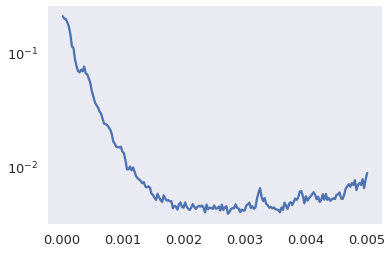

In [40]:
plt.plot(lr, loss)
plt.gca().set_yscale('log')

In [164]:
max_lr = 0.005; base_lr = 0.0001; step_size = train_gen.n_batches * 2

In [165]:
clr = CyclicLR(base_lr=max_lr, max_lr=base_lr, step_size=step_size)

In [166]:
model = fc_model(
    feature_shape,
    target_shape,
    [512],
    1e-3,
    'mse',
    batch_norm=False,
    activation='relu'
)

In [ ]:
train_hist = model.fit_generator(
        train_gen.return_generator(),
        train_gen.n_batches,
        epochs=6,
        workers=8,
        max_queue_size=50,
        callbacks=[clr],
    )

Epoch 1/6
22944/22944 [==============================] - 321s 14ms/step - loss: 0.0027 - rmse: 0.0382 - log_loss: -1.5526 - total_error: 910.9370 - unexplained_error: 327.1655 - rsquared: 0.6408 - total_error_avgAx0: 661.8774 - rsquared_avgAx0: 0.5057
Epoch 2/6
22944/22944 [==============================] - 318s 14ms/step - loss: 0.0024 - rmse: 0.0361 - log_loss: -1.5815 - total_error: 910.9370 - unexplained_error: 290.4414 - rsquared: 0.6810 - total_error_avgAx0: 661.8774 - rsquared_avgAx0: 0.5610
Epoch 3/6
16765/22944 [====================>.........] - ETA: 1:26 - loss: 0.0023 - rmse: 0.0358 - log_loss: -1.5859 - total_error: 910.8917 - unexplained_error: 285.8778 - rsquared: 0.6860 - total_error_avgAx0: 661.8104 - rsquared_avgAx0: 0.5679

In [ ]:
train_